In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Config

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 70
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

ORIG_DATA_DIR = r'E:\Krishi-Sahayak\krishi-model\Data'  # original dataset folder
DATA_DIR = r'E:\Krishi-Sahayak\krishi-model\SplitData' # folder where split dataset will be saved

Split Data

In [3]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    random.seed(seed)
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    print(f"Classes found: {classes}")

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        random.shuffle(files)

        n_total = len(files)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train+n_val],
            'test': files[n_train+n_val:]
        }

        for split_name, split_files in splits.items():
            split_dir = os.path.join(dest_dir, split_name, cls)
            os.makedirs(split_dir, exist_ok=True)

            for file_name in split_files:
                src_file = os.path.join(cls_path, file_name)
                dst_file = os.path.join(split_dir, file_name)
                if not os.path.exists(dst_file):
                    shutil.copy2(src_file, dst_file)
            print(f"Copied {len(split_files)} files to {split_dir}")

In [4]:
# split_data(ORIG_DATA_DIR, DATA_DIR, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

Data Generators

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save labels for inference
os.makedirs("model", exist_ok=True)
with open("model/labels.txt", "w") as f:
    for label in train_generator.class_indices:
        f.write(f"{label}\n")

Found 7990 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.
Found 2674 images belonging to 17 classes.


Build Model

In [6]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('model/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

Initial training

In [8]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.6840 - loss: 2.8488
Epoch 1: val_loss improved from inf to 0.49421, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.6842 - loss: 2.8455 - val_accuracy: 0.8173 - val_loss: 0.4942 - learning_rate: 0.0100
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8039 - loss: 0.6936
Epoch 2: val_loss did not improve from 0.49421
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 947ms/step - accuracy: 0.8039 - loss: 0.6937 - val_accuracy: 0.8124 - val_loss: 0.5311 - learning_rate: 0.0100
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.7968 - loss: 0.6463
Epoch 3: val_loss improved from 0.49421 to 0.41107, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 937ms/step - accuracy: 0.7967 - loss: 0.6464 - val_accuracy: 0.8462 - val_loss: 0.4111 - learning_rate: 0.0100
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.7945 - loss: 0.6657
Epoch 4: val_loss improved from 0.41107 to 0.41049, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 932ms/step - accuracy: 0.7945 - loss: 0.6656 - val_accuracy: 0.8459 - val_loss: 0.4105 - learning_rate: 0.0100
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.7884 - loss: 0.6902
Epoch 5: val_loss improved from 0.41049 to 0.39001, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 942ms/step - accuracy: 0.7884 - loss: 0.6901 - val_accuracy: 0.8635 - val_loss: 0.3900 - learning_rate: 0.0100
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8120 - loss: 0.6018
Epoch 6: val_loss did not improve from 0.39001
250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 935ms/step - accuracy: 0.8120 - loss: 0.6019 - val_accuracy: 0.8466 - val_loss: 0.3979 - learning_rate: 0.0100
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8100 - loss: 0.6206
Epoch 7: val_loss did not improve from 0.39001
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 949ms/step - accuracy: 0.8100 - loss: 0.6206 - val_accuracy: 0.8083 - val_loss: 0.4366 - learning_rate: 0.0100
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.8188 - loss: 0.5850
Epoch 8: val_loss improved from 0.39001 to 0.37443, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 938ms/step - accuracy: 0.8188 - loss: 0.5850 - val_accuracy: 0.8684 - val_loss: 0.3744 - learning_rate: 0.0100
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8153 - loss: 0.5881
Epoch 9: val_loss did not improve from 0.37443
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 932ms/step - accuracy: 0.8153 - loss: 0.5881 - val_accuracy: 0.8526 - val_loss: 0.4250 - learning_rate: 0.0100
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8191 - loss: 0.5891
Epoch 10: val_loss did not improve from 0.37443
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 932ms/step - accuracy: 0.8191 - loss: 0.5893 - val_accuracy: 0.8414 - val_loss: 0.4701 - learning_rate: 0.0100
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8003 - loss: 0.6597
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 11: val_loss did not improve from 0.37443
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 933ms/step - accuracy: 0.8003 - loss: 0.6596 

250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 937ms/step - accuracy: 0.8367 - loss: 0.5145 - val_accuracy: 0.8756 - val_loss: 0.3594 - learning_rate: 0.0050
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8482 - loss: 0.4069
Epoch 13: val_loss improved from 0.35937 to 0.34079, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 937ms/step - accuracy: 0.8482 - loss: 0.4069 - val_accuracy: 0.8774 - val_loss: 0.3408 - learning_rate: 0.0050
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.8543 - loss: 0.3945
Epoch 14: val_loss improved from 0.34079 to 0.33695, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 938ms/step - accuracy: 0.8543 - loss: 0.3946 - val_accuracy: 0.8786 - val_loss: 0.3369 - learning_rate: 0.0050
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8543 - loss: 0.4018
Epoch 15: val_loss improved from 0.33695 to 0.30775, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 939ms/step - accuracy: 0.8543 - loss: 0.4018 - val_accuracy: 0.8816 - val_loss: 0.3077 - learning_rate: 0.0050
Epoch 16/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.8653 - loss: 0.3619
Epoch 16: val_loss did not improve from 0.30775
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 940ms/step - accuracy: 0.8653 - loss: 0.3620 - val_accuracy: 0.8793 - val_loss: 0.3648 - learning_rate: 0.0050
Epoch 17/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.8706 - loss: 0.3783
Epoch 17: val_loss did not improve from 0.30775
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 941ms/step - accuracy: 0.8705 - loss: 0.3783 - val_accuracy: 0.8594 - val_loss: 0.3896 - learning_rate: 0.0050
Epoch 18/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8676 - loss: 0.3620
Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.

Epoch 18: val_loss did not improve from 0.30775
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 942ms/step - accuracy: 0.8676 - loss: 0.36

250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 938ms/step - accuracy: 0.8823 - loss: 0.3236 - val_accuracy: 0.8966 - val_loss: 0.2869 - learning_rate: 0.0025
Epoch 20/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8848 - loss: 0.3070
Epoch 20: val_loss did not improve from 0.28690
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 934ms/step - accuracy: 0.8848 - loss: 0.3071 - val_accuracy: 0.8902 - val_loss: 0.2964 - learning_rate: 0.0025
Epoch 21/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.8747 - loss: 0.3045
Epoch 21: val_loss did not improve from 0.28690
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 932ms/step - accuracy: 0.8747 - loss: 0.3045 - val_accuracy: 0.8887 - val_loss: 0.3119 - learning_rate: 0.0025
Epoch 22/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8842 - loss: 0.3092
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 22: val_loss did not improve from 0.28690
250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 936ms/step - accuracy: 0.8842 - loss: 0.30

250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 943ms/step - accuracy: 0.8808 - loss: 0.3147 - val_accuracy: 0.8985 - val_loss: 0.2810 - learning_rate: 0.0012
Epoch 24/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.8964 - loss: 0.2748
Epoch 24: val_loss improved from 0.28096 to 0.27512, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 234s 936ms/step - accuracy: 0.8964 - loss: 0.2749 - val_accuracy: 0.8962 - val_loss: 0.2751 - learning_rate: 0.0012
Epoch 25/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9006 - loss: 0.2516
Epoch 25: val_loss did not improve from 0.27512
250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 934ms/step - accuracy: 0.9006 - loss: 0.2516 - val_accuracy: 0.8966 - val_loss: 0.2789 - learning_rate: 0.0012
Epoch 26/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8979 - loss: 0.2729
Epoch 26: val_loss improved from 0.27512 to 0.26639, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 939ms/step - accuracy: 0.8978 - loss: 0.2729 - val_accuracy: 0.8992 - val_loss: 0.2664 - learning_rate: 0.0012
Epoch 27/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.8961 - loss: 0.2739
Epoch 27: val_loss did not improve from 0.26639
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 942ms/step - accuracy: 0.8961 - loss: 0.2739 - val_accuracy: 0.8974 - val_loss: 0.2740 - learning_rate: 0.0012
Epoch 28/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.8969 - loss: 0.2723
Epoch 28: val_loss did not improve from 0.26639
250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 942ms/step - accuracy: 0.8969 - loss: 0.2723 - val_accuracy: 0.8985 - val_loss: 0.2680 - learning_rate: 0.0012
Epoch 29/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.8962 - loss: 0.2736
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 29: val_loss did not improve from 0.26639
250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 945ms/step - accuracy: 0.8962 - loss: 0.27

250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 945ms/step - accuracy: 0.9037 - loss: 0.2437 - val_accuracy: 0.9034 - val_loss: 0.2631 - learning_rate: 6.2500e-04
Epoch 33/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9011 - loss: 0.2543
Epoch 33: val_loss did not improve from 0.26314
250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 946ms/step - accuracy: 0.9011 - loss: 0.2543 - val_accuracy: 0.8992 - val_loss: 0.2689 - learning_rate: 6.2500e-04
Epoch 34/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.8981 - loss: 0.2574
Epoch 34: val_loss improved from 0.26314 to 0.25739, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 949ms/step - accuracy: 0.8981 - loss: 0.2574 - val_accuracy: 0.9015 - val_loss: 0.2574 - learning_rate: 6.2500e-04
Epoch 35/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9043 - loss: 0.2477
Epoch 35: val_loss did not improve from 0.25739
250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 944ms/step - accuracy: 0.9043 - loss: 0.2478 - val_accuracy: 0.9011 - val_loss: 0.2660 - learning_rate: 6.2500e-04
Epoch 36/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.9019 - loss: 0.2438
Epoch 36: val_loss did not improve from 0.25739
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 948ms/step - accuracy: 0.9019 - loss: 0.2438 - val_accuracy: 0.9049 - val_loss: 0.2662 - learning_rate: 6.2500e-04
Epoch 37/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8987 - loss: 0.2538
Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 37: val_loss did not improve from 0.25739
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 942ms/step - accuracy: 0.8987 

Fine-tuning

In [9]:
# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:  # unfreeze last 50 layers (can tune this)
    layer.trainable = True

# Compile again with lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 42/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.8327 - loss: 0.5546
Epoch 42: val_loss did not improve from 0.25739
250/250 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.8327 - loss: 0.5542 - val_accuracy: 0.7947 - val_loss: 1.3102 - learning_rate: 1.0000e-04
Epoch 43/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.8777 - loss: 0.3505
Epoch 43: val_loss did not improve from 0.25739
250/250 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.8777 - loss: 0.3504 - val_accuracy: 0.8094 - val_loss: 0.9108 - learning_rate: 1.0000e-04
Epoch 44/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8915 - loss: 0.3187
Epoch 44: val_loss did not improve from 0.25739
250/250 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.8914 - loss: 0.3187 - val_accuracy: 0.8519 - val_loss: 0.4653 - learning_rate: 1.0000e-04
Epoch 45/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8878 - loss: 0.3276
Epoch 45: val_loss did not improve from 0.25739
250/250 ━━

250/250 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.9395 - loss: 0.1733 - val_accuracy: 0.9282 - val_loss: 0.2464 - learning_rate: 5.0000e-05
Epoch 56/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9459 - loss: 0.1548
Epoch 56: val_loss improved from 0.24643 to 0.21503, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9459 - loss: 0.1548 - val_accuracy: 0.9282 - val_loss: 0.2150 - learning_rate: 5.0000e-05
Epoch 57/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9460 - loss: 0.1508
Epoch 57: val_loss did not improve from 0.21503
250/250 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9460 - loss: 0.1508 - val_accuracy: 0.9274 - val_loss: 0.2285 - learning_rate: 5.0000e-05
Epoch 58/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9476 - loss: 0.1576
Epoch 58: val_loss did not improve from 0.21503
250/250 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.9476 - loss: 0.1577 - val_accuracy: 0.9286 - val_loss: 0.2234 - learning_rate: 5.0000e-05
Epoch 59/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9504 - loss: 0.1531
Epoch 59: val_loss improved from 0.21503 to 0.19029, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.9504 - loss: 0.1531 - val_accuracy: 0.9346 - val_loss: 0.1903 - learning_rate: 5.0000e-05
Epoch 60/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9517 - loss: 0.1381
Epoch 60: val_loss did not improve from 0.19029
250/250 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.9517 - loss: 0.1381 - val_accuracy: 0.9305 - val_loss: 0.2112 - learning_rate: 5.0000e-05
Epoch 61/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.9587 - loss: 0.1370
Epoch 61: val_loss did not improve from 0.19029
250/250 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9587 - loss: 0.1370 - val_accuracy: 0.9323 - val_loss: 0.2212 - learning_rate: 5.0000e-05
Epoch 62/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9567 - loss: 0.1358
Epoch 62: val_loss did not improve from 0.19029

Epoch 62: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.9567 - loss: 0

Plot Training Results

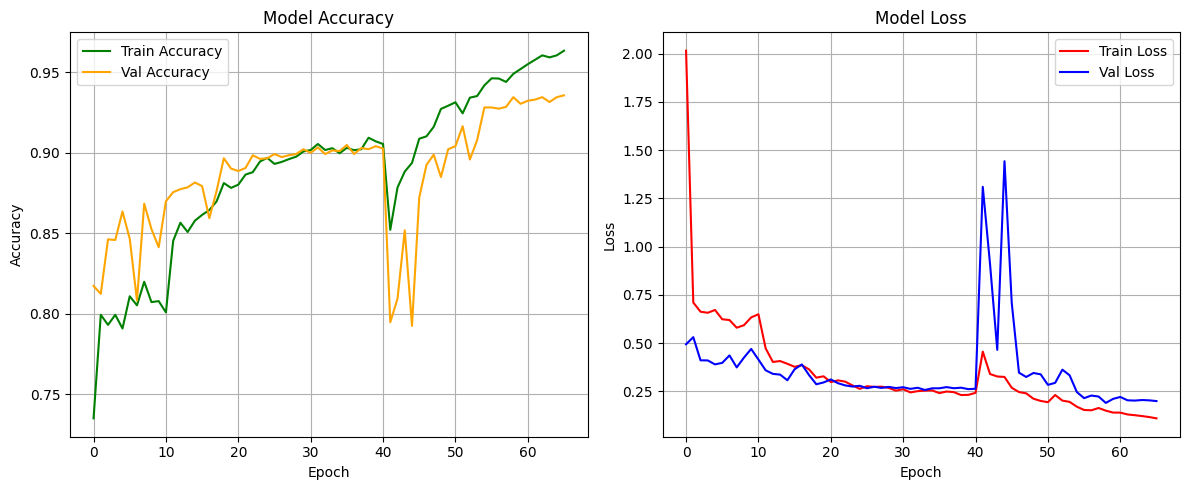

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluate on test set

In [12]:
print("\nEvaluating on test data...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}, Test Loss: {test_loss:.2f}")


Evaluating on test data...
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 587ms/step - accuracy: 0.9473 - loss: 0.1708
Test accuracy: 93.38, Test Loss: 0.20
